In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.4 MB/s eta 0:00:00


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import dataProcess

from datetime import datetime
import matplotlib.pyplot as plt
import optuna
import numpy as np

In [3]:
def nan_to_above(data):
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      for k in range(data.shape[2]):
        if torch.isnan(data[i, j, k]):
          if j == 0:
            data[i, j, k] = 0
          else:
            data[i, j, k] = data[i, j-1, k]

In [4]:
# data preprocessing

# 2014-04-16
start = datetime(2014, 4, 16).date()
# 2024-04-11
end = datetime(2024, 4, 11).date()
hourly_path ='weatherstats_toronto_hourly.csv'
daily_path ='weatherstats_toronto_daily.csv'

# data
data_tensor_preprocess = dataProcess.dataToTensorHourly(hourly_path, separateByDay=False, missingThreshold=0.1, columnToDelete=['wind_dir', 'unixtime'], start=start, end=end)
data_tensor_preprocess_r = torch.flip(data_tensor_preprocess[0], dims=[0])

In [23]:
data = data_tensor_preprocess_r[:-7].reshape(-1, 24, 13)
nan_to_above(data)
print(data.shape)
print(data[0][0])
print(data[0][-1])

torch.Size([3648, 24, 13])
tensor([ 0.0000e+00,  1.0011e+02,  1.0228e+02,  3.0000e+01,  2.7000e+01,
         5.7000e+01, -1.2400e+01, -5.1000e+00,  2.4100e+04,  0.0000e+00,
        -4.9000e+00, -5.1000e+00,  1.0500e+02], dtype=torch.float64)
tensor([ 2.3000e+01,  1.0126e+02,  1.0344e+02,  1.5000e+01,  4.0000e+00,
         6.1000e+01, -6.3000e+00,  4.0000e-01,  2.4100e+04,  2.0000e+00,
         7.0000e-01,  4.0000e-01,  1.0500e+02], dtype=torch.float64)


In [24]:
# targets
targets_1 = dataProcess.dailyTargets(daily_path, start=datetime(2014, 4, 17).date())
targets = torch.flip(targets_1, dims=[0])
print(targets.shape)
print(targets[0])
print(targets[-1])

torch.Size([3648])
tensor(3.7500, dtype=torch.float64)
tensor(11.1500, dtype=torch.float64)


In [40]:
def process_data_for_transformer(train_fraction, valid_fraction, data, targets, batch_size):

  train_dataset = TensorDataset(data, targets)
  total_size = len(data)
  train_split_point = int(total_size * train_fraction)
  valid_split_point = train_split_point + int(total_size * valid_fraction)

  train_dataset = TensorDataset(data[:train_split_point], targets[:train_split_point])
  val_dataset = TensorDataset(data[train_split_point:valid_split_point],
                              targets[train_split_point:valid_split_point])
  test_dataset = TensorDataset(data[valid_split_point:], targets[valid_split_point:])

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = process_data_for_transformer(0.34, 0.3, data, targets, 2048)

In [26]:
class WeatherPredictorTransformer(nn.Module):
  def __init__(self, input_size, d_model, nhead, num_encoder_layers, output_size, dropout_rate):
    super(WeatherPredictorTransformer, self).__init__()
    self.embedding = nn.Linear(input_size, d_model)
    self.positional_encoding = nn.Parameter(self.create_sinusoidal_positional_encoding(24, d_model), requires_grad=False)
    self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout_rate)
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
    self.output_linear = nn.Linear(d_model, output_size)

  def forward(self, x):
    x = self.embedding(x)
    x += self.positional_encoding[:x.size(1), :]
    x = x.permute(1, 0, 2)  # Transformer expects [seq_len, batch_size, features]
    encoder_output = self.transformer_encoder(x)
    prediction = self.output_linear(encoder_output[-1])
    return prediction

  @staticmethod
  def create_sinusoidal_positional_encoding(length, d_model):
    PE = torch.zeros(length, d_model)
    position = torch.arange(0, length, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
    PE[:, 0::2] = torch.sin(position * div_term)
    PE[:, 1::2] = torch.cos(position * div_term)
    return PE


In [34]:
def train_model(trial, model, num_epochs, train_loader, val_loader, device):
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=trial.suggest_float('lr', 1e-6, 1e-3, log=True))

  for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device).float(), targets.to(device).float()
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()

      model.eval()
      total_val_loss = 0
      with torch.no_grad():
        for inputs, targets in val_loader:
          inputs, targets = inputs.to(device).float(), targets.to(device).float()
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          total_val_loss += loss.item()

  return total_val_loss / len(val_loader)

def objective(trial):
  input_size = 13
  d_model = trial.suggest_categorical('d_model', [64, 128, 256])
  nhead = trial.suggest_categorical('nhead', [4, 8])
  num_encoder_layers = trial.suggest_int('num_encoder_layers', 1, 4)
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.3)
  output_size = 1

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = WeatherPredictorTransformer(input_size, d_model, nhead, num_encoder_layers, output_size, dropout_rate)
  model.to(device)

  num_epochs = 50
  return train_model(trial, model, num_epochs, train_loader, val_loader, device)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
for key, value in trial.params.items():
  print(f"    {key}: {value}")

[I 2024-04-18 06:33:48,743] A new study created in memory with name: no-name-3828af8d-ed84-4a8d-8f5c-0fefe6788e32
<ipython-input-34-6104c1009bfc>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.3)
[I 2024-04-18 06:33:52,315] Trial 0 finished with value: 136.39418029785156 and parameters: {'d_model': 64, 'nhead': 4, 'num_encoder_layers': 3, 'dropout_rate': 0.19535055815179594, 'lr': 0.00013556456333667244}. Best is trial 0 with value: 136.39418029785156.
[I 2024-04-18 06:33:56,245] Trial 1 finished with value: 131.65707397460938 and parameters: {'d_model': 64, 'nhead': 4, 'num_encoder_layers': 4, 'dropout_rate': 0.267225081292365, 'lr': 0.0005169816532192858}. Best is trial 1 with value: 131.65707397460938.
[I 2024-04-18 06:34:00,767] Trial 2 finished with value: 135.91018676757812 and

Best trial:
  Value: 120.81112670898438
    d_model: 256
    nhead: 4
    num_encoder_layers: 4
    dropout_rate: 0.07227862766031731
    lr: 2.8100789220517466e-05


Epoch [1/50], Training Loss: 217.4625, Validation Loss: 193.6057
Epoch [2/50], Training Loss: 207.0442, Validation Loss: 185.0063
Epoch [3/50], Training Loss: 197.1522, Validation Loss: 177.0500
Epoch [4/50], Training Loss: 188.0728, Validation Loss: 169.7694
Epoch [5/50], Training Loss: 179.5875, Validation Loss: 163.1774
Epoch [6/50], Training Loss: 171.8390, Validation Loss: 157.2716
Epoch [7/50], Training Loss: 164.8128, Validation Loss: 152.0427
Epoch [8/50], Training Loss: 158.4566, Validation Loss: 147.4595
Epoch [9/50], Training Loss: 152.8264, Validation Loss: 143.4843
Epoch [10/50], Training Loss: 147.9325, Validation Loss: 140.0438
Epoch [11/50], Training Loss: 143.4736, Validation Loss: 137.0694
Epoch [12/50], Training Loss: 139.5380, Validation Loss: 134.5143
Epoch [13/50], Training Loss: 136.2296, Validation Loss: 132.3301
Epoch [14/50], Training Loss: 133.2255, Validation Loss: 130.4766
Epoch [15/50], Training Loss: 130.6198, Validation Loss: 128.9012
Epoch [16/50], Trai

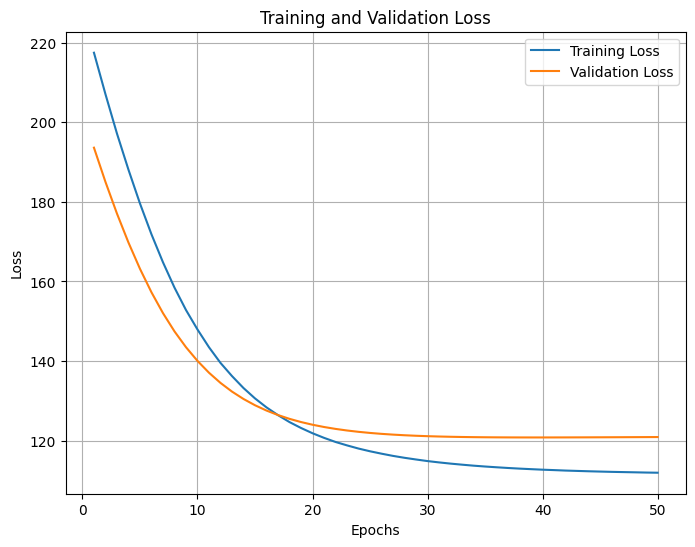

In [45]:
# Device configuration - using GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

learning_rate = 0.000028101
num_epochs = 50

input_size = 13
d_model = 256
nhead = 4
num_encoder_layers = 4
output_size = 1
dropout_rate = 0.072279

# Define your model, optimizer, and loss function
model = WeatherPredictorTransformer(input_size, d_model, nhead, num_encoder_layers, output_size, dropout_rate)
model.to(device)  # Move your model to the configured device
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

def train_model(model, num_epochs, optimizer, criterion, train_loader, val_loader):
  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
      inputs, targets = inputs.float(), targets.float()
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
      for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        inputs, targets = inputs.float(), targets.float()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

  # Plotting
  plt.figure(figsize=(8, 6))
  plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
  plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

# Assuming you have defined train_loader and val_loader
train_model(model, num_epochs, optimizer, criterion, train_loader, val_loader)

In [50]:
def evaluate_model(model, criterion, data_loader, device):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for inputs, targets in data_loader:
      inputs, targets = inputs.to(device).float(), targets.to(device).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      total_loss += loss.item()
  avg_loss = total_loss / len(data_loader)
  return avg_loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

test_loss = evaluate_model(model, criterion, test_loader, device)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 99.7224
